In [2]:
# -*- coding:utf8 -*-
import json
import pandas as pd
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import date, timedelta as td
import random
import math
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

# Data cleaning:

In [3]:
# 读取前10万行
start = time.clock()
path = 'C:/Users/maxiaocheng/Downloads/'
data = pd.read_csv(path+'order_cancel.csv', nrows = 10*10**4 + 1, names = xrange(140))
data.columns = data.iloc[0]
data.drop(data.index[0],inplace=True)
data.drop(['parent_sale_ord_id','user_reg_addr','client_vert',
           'valid_flag','store_id','delv_station_id','carry_bill_id'],
          axis=1,inplace=True)
print (time.clock() - start)/60

0.0507702546703


特征类型:  
1.flag, num, id, cd, amount：先转换为数值型.  
$\qquad$cd类即categorical variable, 一般有两种情况:   
$\qquad$$\qquad$1) 像reg_user_type_cd这种有层级关系的，直接0,1,2..这样编码  
$\qquad$$\qquad$2) 像client这种，('android','apple',...)，没有层级关系，采用one-hot encoding  
2.一列的值一样：删除  
3.带'cancel'的：删除  
4.'tm'类:两两间计算时间差  
5.带'addr','name',一列全为空:删除

In [4]:
# 用户订单数
ord_cnt = data.groupby('user_id')['sale_ord_id'].size().reset_index().rename(columns = {0:'buy_count'})
data = pd.merge(data, ord_cnt, on = 'user_id', how= 'left')
uni_count = ord_cnt.buy_count.unique()
for cnt in uni_count:
    temp_trash = data[data.buy_count == cnt]
    zero_portion = len(temp_trash[temp_trash['cancel_flag'] == 0]) / len(temp_trash)
    one_portion = len(temp_trash[temp_trash['cancel_flag'] == 1]) / len(temp_trash)
    print '{}: {}, {}'.format(cnt, zero_portion, one_portion)

1: 0.858799885742, 0.0995878560353
2: 0.76393442623, 0.227322404372
3: 0.611111111111, 0.388888888889
21: 1.0, 0.0
4: 0.583333333333, 0.416666666667
5: 1.0, 0.0


In [5]:
for col in data.columns:
    portion = len(data[col].unique()) / len(data)
    if portion >= 0.2:
        print '{}: {}'.format(col, portion)

sale_ord_id: 1.0
user_id: 0.9898
user_log_acct: 0.98894
user_reg_tm: 0.98748
ord_tm: 0.53479
pay_tm: 0.44215
ord_proc_tm: 0.53479
out_wh_tm: 0.21717
check_account_tm: 0.45014
place_ord_ip: 0.85399
last_update_tm: 0.51675


In [6]:
# # Need Label
# need_label = ['carry_bill_id','place_ord_ip','src_desc','client']
# for col1 in need_label:
#     #data.drop(col1,axis=1,inplace=True)

In [7]:
# reg_user_type_cd
data.reg_user_type_cd[data.reg_user_type_cd == 'Z'] = -1
data.reg_user_type_cd = pd.to_numeric(data.reg_user_type_cd)

# vat_invoice_flag
le = LabelEncoder()
le.fit(data.vat_invoice_flag)
data.vat_invoice_flag = le.transform(data.vat_invoice_flag)

In [8]:
ord_col = filter(lambda x: 'ord' in x, data.columns)

In [9]:
tm_col = []
for col in data.columns:
    if '_tm' in col and col != 'user_reg_tm' and col != 'ord_tm':
        tm_col.append(col)
tm_col

['pay_tm',
 'ord_proc_tm',
 'ord_cancel_tm',
 'print_tm',
 'sorting_tm',
 'package_tm',
 'out_wh_tm',
 'ship_sorting_tm',
 'check_account_tm',
 'ord_complete_tm',
 'last_update_tm',
 'sorting_center_pop_rev_tm']

In [10]:
for col1 in tm_col:
    data[col1] = pd.to_datetime(data[col1],errors='coerce')

In [11]:
data['user_reg_tm'].head()

0    2009-11-11 00:41:23
1    2015-11-24 16:13:58
2    2017-03-08 12:32:19
3    2015-05-14 05:47:07
4    2017-04-22 21:33:43
Name: user_reg_tm, dtype: object

In [12]:
def print_obj_col():
    for col in data.columns:
        if data[col].dtype == 'O':
            print col

In [13]:
#两两计算时间差
def trans2min(v):
    if pd.notnull(v):
        return v.days * 24 *60 + v.seconds / 3600
    
new_cols = []
for i in xrange(len(tm_col)-1):
    if 'ord' in tm_col:
        continue
    for j in xrange(i+1,len(tm_col)):
        new_col_name = '{}-{}_diff'.format(tm_col[i], tm_col[j])
        data[new_col_name] = data[tm_col[i]] - data[tm_col[j]]
        data[new_col_name] = data[new_col_name].map(trans2min)
        new_cols.append(new_col_name)

In [14]:
# name_col
name_col = filter(lambda x: '_name' in x, data.columns)
data.drop(name_col,axis=1,inplace=True)

In [15]:
# amount col
amount_col = filter(lambda x: 'amount' in x, data.columns)
for col1 in amount_col:
    data[col1] = pd.to_numeric(data[col1])

In [16]:
# Nan cols
for col1 in data.columns:
    if len(data[pd.isnull(data[col1])]) / len(data) == 1:
        print col1
        data.drop(col1,axis=1,inplace=True)

school_agent_acct_num
pay_instalments_fee
pay_instalments_periods
pay_instalments_rate
pay_instalments_ord_id
sorting_tm
rev_addr
cnee_fixed_tel
cnee_mobile_num
cnee_mail_addr
corp
user_point
chan_client_type_cd
pay_tm-sorting_tm_diff
ord_proc_tm-sorting_tm_diff
ord_cancel_tm-sorting_tm_diff
print_tm-sorting_tm_diff
sorting_tm-package_tm_diff
sorting_tm-out_wh_tm_diff
sorting_tm-ship_sorting_tm_diff
sorting_tm-check_account_tm_diff
sorting_tm-ord_complete_tm_diff
sorting_tm-last_update_tm_diff
sorting_tm-sorting_center_pop_rev_tm_diff


In [17]:
#用户年龄
def trans_age(v):
    if pd.notnull(v):
        return v.days / 365

data.reg_birthday = pd.to_datetime(data.reg_birthday,errors='coerce')
data['user_age'] = pd.to_datetime('2017-05-14') - data.reg_birthday
data['user_age'] = data['user_age'].map(trans_age)
data.drop('reg_birthday',axis=1,inplace=True)

In [18]:
#用户注册时间
data['user_reg_tm'] = pd.to_datetime(data['user_reg_tm'],errors='coerce')
data['ord_tm'] = pd.to_datetime(data['ord_tm'],errors='coerce')

data['reg_age'] = pd.to_datetime('2017-05-14') - data['user_reg_tm']
data['reg_age'] = pd.to_numeric(data['reg_age'])

def trans_ord_tm(v):
    return v.hour * 60 + v.minute + v.second/60

data.ord_tm = data.ord_tm.map(trans_ord_tm)
data.drop(['user_reg_tm','ord_tm'],axis=1,inplace=True)

In [19]:
# same col
drop_col = ['ord_dt','dp','dt','carrier_tel','user_log_acct','ord_flag']

for col in drop_col:
    data.drop(col,axis=1,inplace=True)

In [20]:
# cancel_col
cancel_col = filter(lambda x: 'cancel' in x and x != 'cancel_flag', data.columns)
for col in cancel_col:
    data.drop(col,axis=1,inplace=True)

In [21]:
# flag, num, id, num, cd
for col in data.columns:
    try:
        con = 'flag' in col or 'num' in col or 'id' in col or 'num' in col or 'cd' in col
        if con:
            data[col] = pd.to_numeric(data[col],errors='coerce')
    except Exception as e:
        print col

In [22]:
def label(col):
    mask = pd.notnull(data[col])
    le = LabelEncoder()
    le.fit(data[col][mask])
    data[col][mask] = le.transform(data[col][mask])
    data[col] = pd.to_numeric(data[col],errors='coerce')

label('vertical_web_type_cd')

In [23]:
data['client'][data['client'] == 'iPad'] = 'ipad'

condition = (data['client'] != 'android') & \
            (data['client'] != 'apple') & \
            (data['client'] != 'm') & \
            (data['client'] != 'ipad') & \
            (pd.notnull(data['client'])) 

data['client'][condition] = 'other'


In [24]:
# One-hot encoding
def new_dummy(col):
    global data
    dummies = pd.get_dummies(data[col])
    data = pd.concat([data,dummies],axis=1)
    data.drop(col,axis=1,inplace=True)
    
new_dummy('client')
new_dummy('src_desc')

In [25]:
left_obj_col = ['total_shipping_charge',
                'actual_shipping_charge',
                'point',
                'other_offer',
                'place_ord_ip',
                'rev_zip',
                'member_reg_gender',
                'user_point',
                'order_all_weight']

for col in left_obj_col:
    try:
        data[col] = pd.to_numeric(data[col],errors='coerce')
    except Exception as e:
        print col
        continue

user_point


In [26]:
for col in tm_col:
    try:
        data.drop(col,axis=1,inplace=True)
    except Exception as e:
        continue

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 138 entries, sale_ord_id to virtual
dtypes: float64(91), int64(39), uint8(8)
memory usage: 100.7 MB


In [28]:
id_col = filter(lambda x: 'id' in x, data.columns)
id_col

['sale_ord_id',
 'user_id',
 'user_site_province_id',
 'user_site_city_id',
 'user_site_county_id',
 'user_site_school_id',
 'rev_addr_province_id',
 'rev_addr_city_id',
 'rev_addr_county_id',
 'rev_addr_school_id',
 'reg_user_valid_flag',
 'engy_subsidy_amount',
 'worldwide_tax_amount',
 'rev_addr_town_id',
 'android']

### 构造特征的目标是增加信息熵
1.'tm'两两计算时间差  
2.统计用户所在城市人口  
3.用户注册地址和收货地址是否相同  
4.用户订单数  

In [29]:
addr = ['province','city','county','school']
for col in addr:
    new_name = '{}_equal'.format(col)
    user_col = 'user_site_{}_id'.format(col)
    rev_col = 'rev_addr_{}_id'.format(col)
    data[new_name] = 0
    data[new_name][data[user_col] == data[rev_col]] = 1
    if user_col != 'user_site_city_id':
        data.drop([user_col, rev_col],axis=1,inplace=True)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 136 entries, sale_ord_id to school_equal
dtypes: float64(88), int64(40), uint8(8)
memory usage: 99.2 MB


In [31]:
equal_col = filter(lambda x: 'equal' in x, data.columns)

In [32]:
# 比较用户注册地址和收货地址是否相同
for col in equal_col:
    a0 = len(data[(data[col] == 0) & (data['cancel_flag'] == 0)]) / len(data[data[col] == 0])
    a1 = len(data[(data[col] == 0) & (data['cancel_flag'] == 1)]) / len(data[data[col] == 0])
    b0 = len(data[(data[col] == 1) & (data['cancel_flag'] == 0)]) / len(data[data[col] == 1])
    b1 = len(data[(data[col] == 1) & (data['cancel_flag'] == 1)]) / len(data[data[col] == 1])
    print a0, a1, b0, b1
    print '============================='

0.88798588536 0.11201411464 0.904204440003 0.0957955599971
0.88938868815 0.11061131185 0.906246645916 0.0937533540839
0.891546948505 0.108453051495 0.910473623412 0.0895263765884
0.883597628573 0.116402371427 0.89486833306 0.10513166694


In [33]:
people_count = data.groupby(['user_site_city_id'])['user_id'].size().reset_index().rename(columns = {0:'people_count'})
people_count.head()

,user_site_city_id,people_count
0,0.0,43608
1,1.0,4
2,2.0,1
3,72.0,2656
4,78.0,93


In [34]:
data = pd.merge(data, people_count, on = 'user_site_city_id', how = 'left')
data.head(10)

,sale_ord_id,sale_ord_cate_cd,sale_ord_type_cd,user_id,reg_user_type_cd,user_lv_cd,ord_create_user_lv_cd,campus_user_flag,user_site_city_id,rev_addr_city_id,...,m,other,app,supply,virtual,province_equal,city_equal,county_equal,school_equal,people_count
0,54032384624,10,0,4044963,-1,62,62,0,1315.0,1315,...,1,0,1,0,0,1,1,1,1,334.0
1,54032391216,10,0,948514223,1,56,56,0,3971.0,984,...,1,0,1,0,0,0,0,0,1,5.0
2,54032396336,20,22,1419674420,2,56,56,999,NaN,933,...,0,0,1,0,0,0,0,0,0,NaN
3,54032397552,10,0,736369185,-1,56,56,1,988.0,2376,...,1,0,1,0,0,0,0,0,1,836.0
4,54032402608,20,22,1463356522,2,50,50,999,NaN,199,...,0,0,1,0,0,0,0,0,0,NaN
5,54032410128,10,0,815177738,-1,56,56,1,83.0,1233,...,1,0,1,0,0,0,0,0,1,725.0
6,54032413296,10,0,891450845,-1,62,62,1,0.0,258,...,0,0,1,0,0,0,0,0,1,43608.0
7,54032413328,20,22,1192535148,22,56,56,0,0.0,988,...,0,0,1,0,0,0,0,0,1,43608.0
8,54032422640,10,0,1395539588,2,56,56,999,NaN,988,...,0,0,1,0,0,0,0,0,0,NaN
9,54032433552,10,0,583806018,-1,62,62,0,0.0,939,...,0,0,1,0,0,0,0,0,1,43608.0


In [35]:
sort_people = people_count.sort(['people_count','user_site_city_id'], ascending=[False, False])
sort_people.head()

,user_site_city_id,people_count
0,0.0,43608
3,72.0,2656
189,1601.0,1778
190,1607.0,1762
234,1930.0,1486


In [36]:
amt_col = ['no_prefr_total_amount',
          'after_prefr_amount',
          'total_offer_amount',
          'sku_offer_amount',
          'user_actual_pay_amount']
         
for col in amt_col:
    new_col = '{}_per_weight'.format(col)
    data[new_col] = data[col] / data['order_all_weight']

data['offer perct'] = data['total_offer_amount'] / data['no_prefr_total_amount']
data['discount perct'] = data['user_actual_pay_amount'] / data['no_prefr_total_amount']

In [41]:
for col in data.columns:
    nan_portion = len(data[pd.isnull(data[col])]) / len(data)
    if nan_portion != 0:
        print '{}: {}'.format(col, nan_portion)

user_site_city_id: 0.22021
sku_offer_amount: 0.30346
suit_offer_amount: 0.30346
gp_offer_amount: 0.30346
full_rebate_offer_amount: 0.30346
telecom_point_offer_amount: 0.30346
dq_and_jq_pay_amount: 0.30346
dq_pay_amount: 0.30346
jq_pay_amount: 0.30346
gift_cps_pay_amount: 0.30346
mobile_red_packet_pay_amount: 0.30346
delv_center_num: 0.15662
place_ord_ip: 1.0
vertical_web_type_cd: 0.38908
rev_zip: 0.99989
member_reg_gender: 0.00554
reg_user_valid_flag: 0.00158
ps_delv_way_cd: 0.77011
acct_bal_pay_amount: 0.30346
flash_gp_offer_amount: 0.30346
jbean_pay_amount: 0.30346
sku_rebate_amount: 0.30346
yixun_point_pay_amount: 0.30346
freight_coupon_amount: 0.30346
pop_shop_lim_sku_jq_pay_amount: 0.30346
pop_shop_lim_sku_dq_pay_amount: 0.30346
engy_subsidy_amount: 0.30346
union_coupon_pay_amount: 0.30346
delv_ser_fee_amount: 0.30346
worldwide_tax_amount: 0.30346
afs_ser_fee_amount: 0.30346
pay_tm-ord_proc_tm_diff: 0.29657
pay_tm-print_tm_diff: 0.62183
pay_tm-package_tm_diff: 0.80149
pay_tm-out_w

In [73]:
data.to_csv('train.csv',index=False)

In [75]:
filter(lambda x: 'id' in x, data.columns)

['sale_ord_id',
 'user_id',
 'user_site_city_id',
 'rev_addr_city_id',
 'reg_user_valid_flag',
 'engy_subsidy_amount',
 'worldwide_tax_amount',
 'rev_addr_town_id',
 'android']

============================================================================

## 3.ML

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [63]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost import XGBClassifier
import xgboost as xgb

ImportError: No module named xgboost

In [279]:
ori_data = pd.read_csv('train.csv')
ori_data.drop('sorting_center_pop_rev_tm',axis=1,inplace=True)

In [306]:
tmp_test = data.limit(5*10**5).toPandas()
y = tmp_test.cancel_flag
tmp_test.drop('cancel_flag',axis=1,inplace=True)
X = tmp_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2017)

In [74]:
data.drop('user_id',axis=1,inplace=True)
y = data.cancel_flag
data.drop('cancel_flag',axis=1,inplace=True)
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2017)

In [282]:
# Scoring
def print_scoring(model, X_test, y_test):
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average='binary')
    print 'Recall: {}'.format(recall)
    print '==========================='
    precision = precision_score(y_test, y_pred, average='binary')
    print 'Precision: {}'.format(precision)
    print '==========================='
    accuracy = accuracy_score(y_test, y_pred)
    print 'Accuracy: {}'.format(accuracy)

In [37]:
# Importance
def print_impor(model,X_train,top=50):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    for i in xrange(top):
        print '{}: {}'.format(X_train.columns[indices][::-1][i], importances[indices][::-1][i])
    print '===================================================='
    print 'Top {} Cumulative Importance: {}'.format(top,sum(importances[indices][::-1][:50]))

### 1.XGB

In [ ]:
"""
--- Grid Search Completed: 51.62 minutes ---
Param grid:
{'n_estimators': [50, 80, 100, 200], 'subsample': [0.7, 0.8], 'learning_rate': [0.05, 0.08, 0.1], 'max_depth': [7, 9, 10]}
Best Params:
{'n_estimators': 200, 'subsample': 0.8, 'learning_rate': 0.08, 'max_depth': 7}
Best CV Score:
-0.99870708255

"""
start_time = time.clock()
clf = xgb.XGBClassifier(seed=2017,objective='binary:logistic')
param_grid = {
        'n_estimators': [200,500,1000],
        'learning_rate': [0.05,0.08,0.1],
        'max_depth': [7, 10, 15],
        'subsample': [0.7, 0.8]
    }

model = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=8,cv=5,verbose=20,scoring='roc_auc')
model.fit(X_train,y_train)

print('--- Grid Search Completed: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))
print('Param grid:')
print(param_grid)
print('Best Params:')
print(model.best_params_)
print('Best CV Score:')
print(-model.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:  6.2min
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:  6.2min
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:  6.3min
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed: 12.9min
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed: 13.1min
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed: 21.8min
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed: 22.0min
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed: 22.2min
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed: 22.3min
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed: 22.6min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 22.7min
[Parallel(n_jobs=8)]: Do

### 由于这是一个unbalanced data问题，88%用户没有取消订单，12%取消了订单，所以我们更应该关注recall和precision,accuracy基本是不能反映模型好坏的，即便不用任何算法，近来一组数据就判断不会取消，我们也有88%的准确率。

### xgb结果

In [1]:
from IPython.display import Image

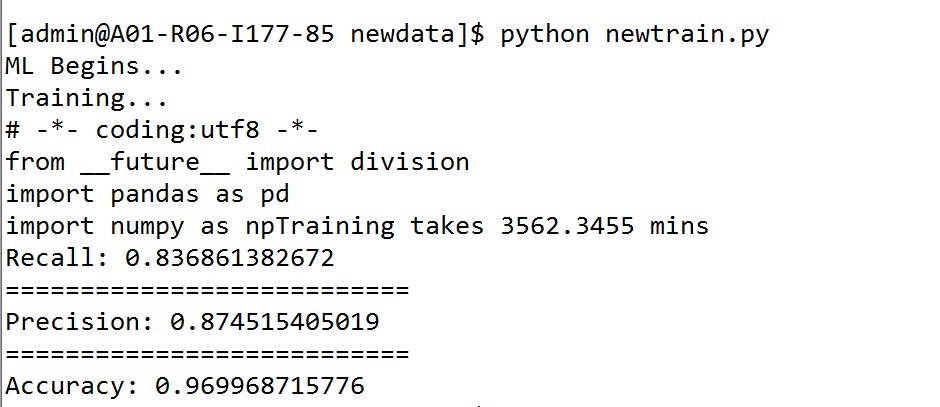

In [5]:
Image("C:/Users/maxiaocheng/Desktop/xgb.png")

## lightGBM结果

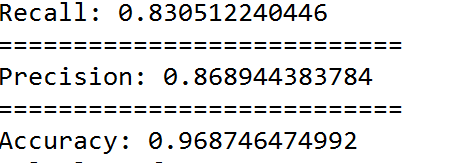

In [8]:
Image("C:/Users/maxiaocheng/Desktop/lgb.png")

In [75]:
xgb_best = xgb.XGBClassifier(seed=2017,objective='binary:logistic',n_estimators = 500,
                             subsample = 0.8, learning_rate = 0.05, max_depth = 10)
xgb_best.fit(X_train,y_train)
y_pred = xgb_best.predict(X_test)
recall = recall_score(y_test, y_pred, average='binary')
print 'Recall: {}'.format(recall)
print '==========================='
precision = precision_score(y_test, y_pred, average='binary')
print 'Precision: {}'.format(precision)
print '==========================='
accuracy = accuracy_score(y_test, y_pred)
print 'Accuracy: {}'.format(accuracy)

Recall: 0.782527007985
Precision: 0.866655106641
Accuracy: 0.964033333333


In [174]:
# 后30万做test
y_pred = xgb_best.predict(X_test)
recall = recall_score(y_test, y_pred, average='binary')
print 'Recall: {}'.format(recall)
print '==========================='
precision = precision_score(y_test, y_pred, average='binary')
print 'Precision: {}'.format(precision)
print '==========================='
accuracy = accuracy_score(y_test, y_pred)
print 'Accuracy: {}'.format(accuracy)

Recall: 0.653293945747
Precision: 0.972664932608
Accuracy: 0.96169


In [ ]:
data = data.iloc[20*10**4:50*10**4]
y_test = data['cancel_flag']
data.drop('cancel_flag',axis=1,inplace=True)
X_test = data
X_test.drop('user_id',axis=1,inplace=True)
y_pred = xgb_best.predict(X_test)
recall = recall_score(y_test, y_pred, average='binary')
print 'Recall: {}'.format(recall)
print '==========================='
precision = precision_score(y_test, y_pred, average='binary')
print 'Precision: {}'.format(precision)
print '==========================='
accuracy = accuracy_score(y_test, y_pred)
print 'Accuracy: {}'.format(accuracy)

In [175]:
print_impor(xgb_best,X_train)

reg_age: 0.11874114722
order_all_weight: 0.0901952311397
after_prefr_amount: 0.0747059211135
rev_addr_town_id: 0.0718112960458
no_prefr_total_amount: 0.0704409703612
delv_center_num: 0.0564143620431
total_offer_amount: 0.0414793379605
user_age: 0.0412483848631
promotion_discount_amount: 0.0272371750325
subd_num: 0.0251893829554
ord_proc_tm-last_update_tm_diff: 0.0211245920509
user_lv_cd: 0.0183223504573
vertical_web_type_cd: 0.0182453654706
reg_user_type_cd: 0.0177372675389
pay_tm-ord_proc_tm_diff: 0.0145347043872
member_reg_gender: 0.013056599535
211_ord_flag: 0.01216357667
sku_offer_amount: 0.0121327834204
sale_ord_type_cd: 0.0107470592484
ord_syn_status_cd: 0.00997721217573
ord_proc_tm-check_account_tm_diff: 0.00970006734133
total_shipping_charge: 0.00970006734133
pay_tm-last_update_tm_diff: 0.00968467071652
android: 0.00926895346493
campus_user_flag: 0.00909958779812
pay_discount_amount: 0.00882244296372
check_account_tm-last_update_tm_diff: 0.00726735219359
apple: 0.00720576476306

In [33]:
import pickle
pickle.dump(xgb_best, open("pima.pickle.dat", "wb"))

In [35]:
import pickle
loaded_model = pickle.load(open("pima.pickle.dat", "rb"))
# make predictions for test data
y_pred = loaded_model.predict(X_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [64]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count, sum
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *


sqlContext = SQLContext(sc)

In [67]:
from __future__ import division
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.dates as dates

import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import os
import time
from datetime import date, timedelta as td
import pickle
%matplotlib inline

In [68]:
from splearn.preprocessing import SparkLabelEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.sql.functions import *
from pyspark.sql.functions import datediff, to_date, lit

In [244]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import monotonically_increasing_id
from sklearn.preprocessing import LabelEncoder
from pyspark.sql.functions import split, col
import datetime

In [227]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [242]:
start = time.clock()
data = sqlContext.read.load('D:/jd intern/oneday.csv', 
                            format='com.databricks.spark.csv', 
                            header='true', 
                            inferSchema='true')
print time.clock() - start

63.5126036444


In [245]:

# reg_user_type_cd
data = data.withColumn('reg_user_type_cd', F.when(data['reg_user_type_cd'] == 'Z', -1).otherwise(data['reg_user_type_cd']))
data = data.withColumn("reg_user_type_cd", data["reg_user_type_cd"].cast(IntegerType()))
# vat_invoice_flag
indexer = StringIndexer(inputCol="vat_invoice_flag", outputCol="vat_invoice_flagIndex") 
indexed = indexer.fit(data).transform(data) 

drop_list = ["vat_invoice_flag"]
indexed = indexed.select([column for column in indexed.columns if column not in drop_list])
#indexed = indexed.drop('vat_invoice_flag')

mapping = {'vat_invoice_flagIndex':'vat_invoice_flag'}
data = indexed.select([col(c).alias(mapping.get(c, c)) for c in indexed.columns])

data = data.drop('sorting_tm')

tm_col = []
for col1 in data.columns:
    if '_tm' in col1 and col1 != 'user_reg_tm' and col1 != 'ord_tm':
        tm_col.append(col1)
for i in xrange(len(tm_col)):
    try:
        col_name = tm_col[i]
        data = data.withColumn(col_name, data[col_name].cast(StringType()))
        data = data.withColumn("test", split(col(col_name)," ").cast("array<String>")) \
                    .withColumn("time", split(col("test")[1],":").cast("array<int>")) \
                    .withColumn("minute", col('time')[1].cast(IntegerType())) \
                    .withColumn("sec", col('time')[2].cast(IntegerType())) \
                    .withColumn(col_name, col('minute') * 60 + col('sec'))
        drop_col = ['test','minute','sec','time'] 
        for col1 in drop_col:
            data = data.drop(col1)
        print '{} done'.format(col_name)
    except Exception as e:
        print i

# name_col
name_col = filter(lambda x: '_name' in x, data.columns)
data = data.select([column for column in data.columns if column not in name_col])

def label(data, col):
    mask = pd.notnull(data[col])
    le = LabelEncoder()
    le.fit(data[col][mask])
    data[col][mask] = le.transform(data[col][mask])
    data[col] = pd.to_numeric(data[col],errors='coerce')

start = time.clock()
"""
need_label = ['carry_bill_id', 'place_ord_ip']
for col in need_label:
    a = data.select(col).toPandas()
    label(a, col)
    
    spark_df = sqlContext.createDataFrame(a)
    spark_df = spark_df.withColumn('id', monotonically_increasing_id())
    data = data.withColumn('id', monotonically_increasing_id())
    data = data.drop(col)
    data = data.join(spark_df, data.id == spark_df.id, 'inner').drop(spark_df.id)
    data = data.drop(data.id)
    print '{} Done.'.format(col)
    print 'Elapsed: {}'.format(time.clock() - start)
"""

need_label = ['carry_bill_id', 'place_ord_ip']
for col1 in need_label:
    data = data.drop(col1)

# user age
data = data.withColumn('user_age',
                      datediff(to_date(lit('2017-05-14')),
                               to_date(unix_timestamp('reg_birthday', "yyyy-MM-dd").cast("timestamp"))))
data = data.drop('reg_birthday')
# cancel col
cancel_col = filter(lambda x:'cancel' in x and x != 'cancel_flag', data.columns)
for col in cancel_col:
    data = data.drop(col)

# 一列的值一样
same_col = ['ord_dt','dp','dt',
            'sale_ord_cancel_type_cd','ord_cancel_rsn_cd','carrier_tel',
            'user_log_acct']

data = data.withColumn('reg_age',
                      datediff(to_date(lit('2017-05-14')),
                               to_date(unix_timestamp('user_reg_tm', "yyyy-MM-dd").cast("timestamp"))))
data = data.drop('user_reg_tm')

def trans_ord_tm(v):
    return v.hour * 3600 + v.minute * 60 + v.second
    
udf_trans_ord_tm = udf(trans_ord_tm, IntegerType())
data = data.withColumn('ord_tm', udf_trans_ord_tm(data['ord_tm']))

# 删除一列的值一样
for col in same_col:
    data = data.drop(col)

"""
start = time.clock()
col = 'client'
a = data.select(col).toPandas()
label(a, col)


spark_df = sqlContext.createDataFrame(a)
spark_df = spark_df.withColumn('id', monotonically_increasing_id())
data = data.withColumn('id', monotonically_increasing_id())
data = data.drop(col)
data = data.join(spark_df, data.id == spark_df.id, 'inner').drop(spark_df.id)
data = data.drop(data.id)
print '{} Done.'.format(col)
print 'Elapsed: {}'.format(time.clock() - start)
"""

"""
col = 'src_desc'
a = data.select(col).toPandas()
dummies = pd.get_dummies(a[col])
a = pd.concat([a,dummies],axis=1)
a.drop(col,axis=1,inplace=True)

spark_df = sqlContext.createDataFrame(a)
spark_df = spark_df.withColumn('id', monotonically_increasing_id())
data = data.withColumn('id', monotonically_increasing_id())
data = data.drop(col)
data = data.join(spark_df, data.id == spark_df.id, 'inner').drop(spark_df.id)
data = data.drop(data.id)
print '{} Done.'.format(col)
print 'Elapsed: {}'.format(time.clock() - start)
"""
need_label = ['carry_bill_id','place_ord_ip','src_desc','client','sorting_center_pop_rev_tm']
for col1 in need_label:
    data = data.drop(col1)

data = data.drop('client_vert')

# drop相关系数大的col
coef_col = [ 'ord_status_cd_2',
             'split_status_cd',
             'ord_syn_status_cd',
             'ord_status_cd_1',
             'campus_sta_flag',
             'pre_sorting_flag',
             'valid_flag' ]

for col in coef_col:
    data = data.drop(col)

# drop 'ord' col
ord_col = filter(lambda x: 'ord' in x, data.columns)
for col in ord_col:
    data = data.drop(col)

# drop 'id' col
id_col = ['user_id','carry_bill_id','store_id','delv_station_id','check_account_tm','last_update_tm']
for col in id_col:
    data = data.drop(col)

# drop Nan col
nan_col = ['school_agent_acct_num',
             'pay_instalments_fee',
             'pay_instalments_periods',
             'pay_instalments_rate',
             'sorting_tm',
             'rev_addr',
             'cnee_fixed_tel',
             'cnee_mobile_num',
             'cnee_mail_addr',
             'user_reg_addr',
             'corp',
             'user_point',
             'chan_client_type_cd',
             'rev_zip']
for col1 in nan_col:
    data = data.drop(col1)

obj_col = [item[0] for item in data.dtypes if item[1] == 'string']
for col1 in obj_col:
    data = data.withColumn(col1, data[col1].cast(IntegerType()))


pay_tm done
ord_proc_tm done
ord_cancel_tm done
print_tm done
package_tm done
out_wh_tm done
ship_sorting_tm done
check_account_tm done
ord_complete_tm done
last_update_tm done
sorting_center_pop_rev_tm done


In [301]:
tmp_test = data.limit(500000).toPandas()
original_data = pd.read_csv('train.csv')
original_data.drop('sorting_center_pop_rev_tm',axis=1,inplace=True)
set(original_data.columns) - set(tmp_test.columns), set(tmp_test.columns)-set(original_data.columns) 

(set(), set())

In [302]:
temp_y_test = tmp_test.cancel_flag
tmp_test.drop('cancel_flag',axis=1,inplace=True)
temp_X_test = tmp_test

#print_scoring(xgb_best, temp_X_test, temp_y_test)

In [303]:
y_pred = xgb_best.predict(temp_X_test.values)
recall = recall_score(temp_y_test, y_pred, average='binary')
print 'Recall: {}'.format(recall)
print '==========================='
precision = precision_score(temp_y_test, y_pred, average='binary')
print 'Precision: {}'.format(precision)
print '==========================='
accuracy = accuracy_score(temp_y_test, y_pred)
print 'Accuracy: {}'.format(accuracy)

Recall: 0.0127252038688
Precision: 0.320592451027
Accuracy: 0.893038


In [311]:
print_impor(xgb_best,X_train)

after_prefr_amount: 0.0717571899295
reg_age: 0.061045113951
no_prefr_total_amount: 0.0576804243028
rev_addr_county_id: 0.0480670183897
pay_tm: 0.0462130047381
user_age: 0.0441529899836
vertical_web_type_cd: 0.0440156571567
delv_center_num: 0.0412689708173
rev_addr_city_id: 0.0381789468229
total_offer_amount: 0.0305568911135
subd_num: 0.0297328848392
rev_addr_town_id: 0.0286342091858
user_actual_pay_amount: 0.0284282080829
sku_offer_amount: 0.0280848722905
out_wh_tm: 0.025818856433
print_tm: 0.0232095029205
rev_addr_province_id: 0.0232095029205
package_tm: 0.0225228313357
ship_sorting_tm: 0.0207374859601
pay_mode_cd: 0.0200508143753
user_site_city_id: 0.0182654671371
user_site_province_id: 0.0181281324476
pay_discount_amount: 0.0175101291388
user_site_county_id: 0.0175101291388
user_lv_cd: 0.0169607903808
reg_user_type_cd: 0.0169607903808
promotion_discount_amount: 0.0164801217616
dq_and_jq_pay_amount: 0.0156561154872
total_shipping_charge: 0.0150381103158
easy_pur_flag: 0.0142827713862

AttributeError: 'numpy.ndarray' object has no attribute '_get_object_id'

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
print_scoring(model.best_estimator_,X_test,y_test)

In [33]:
print_impor(model.best_estimator_,X_train)

pay_tm: 0.0866967588663
reg_age: 0.075411580503
after_prefr_amount: 0.0617365911603
vertical_web_type_cd: 0.0580191202462
no_prefr_total_amount: 0.0508497096598
rev_addr_county_id: 0.0491237379611
rev_addr_city_id: 0.0398300588131
sku_offer_amount: 0.039298992604
delv_center_num: 0.0389006920159
rev_addr_town_id: 0.0355815179646
user_actual_pay_amount: 0.0346521511674
out_wh_tm: 0.0310674458742
print_tm: 0.0273499730974
pay_mode_cd: 0.0273499730974
user_site_city_id: 0.0265533719212
total_offer_amount: 0.0258895382285
ship_sorting_tm: 0.0252257045358
user_lv_cd: 0.0211099311709
user_site_province_id: 0.0209771636873
user_site_county_id: 0.0209771636873
rev_addr_province_id: 0.0193839613348
user_age: 0.0191184282303
reg_user_type_cd: 0.0167286247015
pay_discount_amount: 0.0142060546204
promotion_discount_amount: 0.0140732871369
dq_and_jq_pay_amount: 0.0128783853725
full_rebate_offer_amount: 0.0115507170558
print_status_cd: 0.00995751470327
subd_num: 0.00929368007928
package_tm: 0.009160

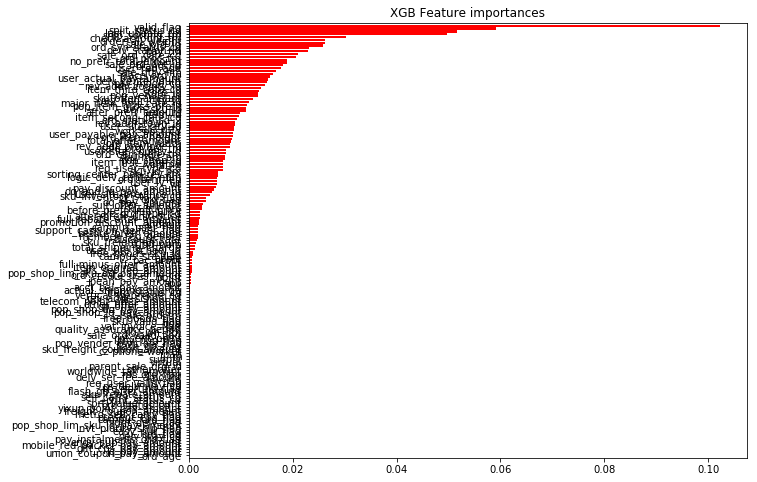

In [111]:
importances = model.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,8))
plt.title("XGB Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
           color="r", align="center")

plt.yticks(range(X_train.shape[1]), X_train.columns[indices],rotation='horizontal')
plt.ylim([-1, X_train.shape[1]])
plt.show()

### 2. RF 

In [79]:
data = data.fillna(0)

In [81]:
start_time = time.clock()
rf = RandomForestClassifier(n_jobs=4, random_state=2017, verbose=1)

param_grid = {'n_estimators': [50,80,100,200,500]}
rf_model = GridSearchCV(estimator=rf, param_grid=param_grid,cv=5, verbose=20)
rf_model.fit(X_train, y_train)

print('--- Grid Search Completed: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))
print('Best Params:')
print(rf_model.best_params_)
print('Best CV Score:')
print(-rf_model.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .................. n_estimators=50, score=0.976404, total=   0.7s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] .................. n_estimators=50, score=0.979658, total=   0.7s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s


[CV] .................. n_estimators=50, score=0.979387, total=   0.7s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.1s remaining:    0.0s


[CV] .................. n_estimators=50, score=0.974227, total=   0.7s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.1s remaining:    0.0s


[CV] .................. n_estimators=50, score=0.978833, total=   0.7s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.1s remaining:    0.0s


[CV] .................. n_estimators=80, score=0.976675, total=   0.7s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.2s remaining:    0.0s


[CV] .................. n_estimators=80, score=0.978031, total=   0.7s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished


[CV] .................. n_estimators=80, score=0.979929, total=   0.8s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.5s remaining:    0.0s


[CV] .................. n_estimators=80, score=0.971785, total=   0.7s
[CV] n_estimators=80 .................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.5s remaining:    0.0s


[CV] .................. n_estimators=80, score=0.979919, total=   0.7s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   12.0s remaining:    0.0s


[CV] ................. n_estimators=100, score=0.976675, total=   1.1s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV] ................. n_estimators=100, score=0.978302, total=   1.1s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV] ................. n_estimators=100, score=0.980743, total=   0.9s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   16.3s remaining:    0.0s


[CV] ................. n_estimators=100, score=0.972056, total=   1.0s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   17.8s remaining:    0.0s


[CV] ................. n_estimators=100, score=0.979647, total=   1.2s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   20.0s remaining:    0.0s


[CV] ................. n_estimators=200, score=0.975319, total=   1.8s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   22.5s remaining:    0.0s


[CV] ................. n_estimators=200, score=0.978573, total=   1.8s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   24.9s remaining:    0.0s


[CV] ................. n_estimators=200, score=0.979929, total=   1.8s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   27.3s remaining:    0.0s


[CV] ................. n_estimators=200, score=0.971243, total=   1.8s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished


[CV] ................. n_estimators=200, score=0.979647, total=   2.1s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished


[CV] ................. n_estimators=500, score=0.974234, total=   4.3s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished


[CV] ................. n_estimators=500, score=0.976675, total=   4.5s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished


[CV] ................. n_estimators=500, score=0.980472, total=   4.4s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished


[CV] ................. n_estimators=500, score=0.971514, total=   4.5s
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.7s finished


[CV] ................. n_estimators=500, score=0.979376, total=   4.5s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   57.0s finished


--- Grid Search Completed: 0.96 minutes ---
Best Params:
{'n_estimators': 50}
Best CV Score:
-0.977701822917


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.3s finished


In [256]:
index = np.argsort(X_test.iloc[0])
X_test.columns[index][::-1]

Index([u'afs_ser_fee_amount', u'sale_ord_id', u'parent_sale_ord_id',
       u'sale_ord_tm', u'sale_ord_det_tm', u'free_goods_sku_id',
       u'user_payable_pay_amount', u'sku_freight_coupon_amount',
       u'worldwide_tax_amount', u'rev_addr_county_id',
       ...
       u'present_cps_flag', u'campus_ord_flag', u'night_delv_flag',
       u'211_ord_flag', u'invt_piority_ship_flag', u'easy_pur_flag',
       u'ord_flag', u'delv_ser_fee_amount', u'pay_instalments_ord_flag',
       u'acct_bal_pay_amount'],
      dtype='object', length=150)

In [82]:
rf_pred = rf_model.best_estimator_.predict(X_test)
print_scoring(rf_model.best_estimator_,X_test,y_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Recall: 0.94124559342
Precision: 0.972677595628
Accuracy: 0.98164556962


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


In [83]:
print_impor(rf_model.best_estimator_,X_train)

user_actual_pay_amount: 0.165506235286
pay_tm: 0.155467967775
pay_mode_cd: 0.0758311735036
ship_sorting_tm: 0.0699812280947
out_wh_tm: 0.0638145494912
print_tm: 0.0565318616358
delv_center_num: 0.0339157027255
after_prefr_amount: 0.0260776550354
no_prefr_total_amount: 0.0250572496303
vertical_web_type_cd: 0.0247025998916
item_original_amount: 0.0225938130445
rev_addr_city_id: 0.0202471218408
reg_age: 0.0199535405144
sku_offer_amount: 0.0197293133285
promotion_discount_amount: 0.0164967637932
subd_num: 0.0159429471905
total_offer_amount: 0.0159197787361
user_lv_cd: 0.0156640749039
rev_addr_province_id: 0.013067370156
rev_addr_county_id: 0.0128156834104
reg_user_type_cd: 0.0100685677965
rev_addr_town_id: 0.00931108451979
ps_delv_way_cd: 0.00809051282027
print_status_cd: 0.00804433593777
package_tm: 0.00740097119969
pay_discount_amount: 0.00655357931263
user_site_province_id: 0.00633340366763
dq_and_jq_pay_amount: 0.00631210634657
total_shipping_charge: 0.00605199359537
user_site_city_id:

### 3.GB

In [262]:
start_time = time.clock()
gbc = GradientBoostingClassifier(random_state=2017, verbose=1)

param_grid = {
    'n_estimators': [20,30,50,60,70,80,90,100,200],
    'learning_rate': [0.05,0.1],
    'subsample': [0.7,0.75,0.8]
}
gb = GridSearchCV(estimator=gbc, param_grid=param_grid,n_jobs=8,cv=5,verbose=20,scoring='roc_auc')
gb.fit(X_train.values, y_train.values)

print('--- Grid Search Completed: %s minutes ---' % round(((time.clock() - start_time) / 60), 2))
print('Best Params:')
print(model.best_params_)
print('Best CV Score:')
print(-model.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   10.3s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:   10.8s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:   11.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   20.6s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   20.7s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:   21.2s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:   21.2s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:   21.6s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:   21.8s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:   21.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   26.3s
[Parallel(n_jobs=8)]: Do

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8666           0.0858           24.88s
         2           0.8056           0.0663           26.63s
         3           0.7480           0.0561           26.86s
         4           0.6964           0.0477           26.21s
         5           0.6579           0.0410           26.32s
         6           0.6144           0.0379           26.42s
         7           0.5833           0.0340           25.97s
         8           0.5516           0.0308           25.66s
         9           0.5283           0.0272           25.68s
        10           0.5021           0.0253           25.65s
        20           0.3344           0.0122           24.41s
        30           0.2310           0.0108           23.22s
        40           0.1612           0.0056           22.22s
        50           0.1168           0.0028           21.29s
        60           0.0951           0.0024           20.69s
       

In [84]:
gb_best = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=2017,
              subsample=0.75, verbose=1, warm_start=False)
gb_best.fit(X_train, y_train)
print_scoring(gb_best, X_test, y_test)
print '========================='
print_impor(gb_best,X_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9371           0.0754           10.35s
         2           0.8666           0.0633           10.00s
         3           0.8152           0.0537           10.11s
         4           0.7687           0.0464           10.14s
         5           0.7297           0.0404           10.26s
         6           0.6875           0.0376           10.12s
         7           0.6558           0.0332           10.12s
         8           0.6298           0.0275           10.03s
         9           0.6014           0.0279           10.12s
        10           0.5802           0.0253           10.11s
        20           0.4065           0.0124            9.86s
        30           0.3238           0.0060            9.45s
        40           0.2743           0.0031            8.98s
        50           0.2464           0.0031            8.37s
        60           0.2222           0.0011            7.63s
       

In [264]:
gb.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=2017,
              subsample=0.75, verbose=1, warm_start=False)

In [263]:
print_scoring(gb.best_estimator_, X_test, y_test)

Recall: 0.989509022241
Precision: 0.997884045705
Accuracy: 0.997745208568


In [269]:
print_impor(gb,X_train)

split_status_cd: 0.168894967864
ord_status_cd_2: 0.0901963838545
ord_complete_tm: 0.0781021703181
valid_flag: 0.0446497947724
sale_ord_valid_flag: 0.0415153809369
ord_syn_status_cd: 0.0347736109733
user_actual_pay_amount: 0.0343244668256
pay_mode_cd: 0.0322592069299
ord_status_cd_1: 0.0313168194339
check_account_tm: 0.0274565321746
last_update_tm: 0.0274477567488
sale_qtty_lim: 0.020891496341
store_id: 0.0191099808564
pay_tm: 0.0186424058434
ord_age: 0.0163590511379
sku_offer_amount: 0.0154078951399
user_site_county_id: 0.01435283456
vertical_web_type_cd: 0.0127074970837
sale_ord_tm: 0.0124496810547
item_sku_id: 0.0121842850107
ord_proc_tm: 0.0111569006579
logic_delv_center_num: 0.0105786722699
sale_ord_det_tm: 0.0103806902266
delv_station_id: 0.0101747100014
no_prefr_total_amount: 0.00970045183676
android: 0.00964017300785
item_original_amount: 0.00935247969186
rev_addr_county_id: 0.00819474067854
virtual: 0.00787836866941
suit_offer_amount: 0.00786751308342
total_offer_amount: 0.0074

In [53]:
gb_pred = gb_best.predict(X_test)
gb_pred[:20]

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int64)